In [2]:
import os
import numpy as np
import torch
from glob import glob
import lightning.pytorch as pl
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from PIL import Image
from albumentations import Compose, HorizontalFlip, VerticalFlip
from albumentations.pytorch import ToTensorV2
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor, SegformerFeatureExtractor
import matplotlib.pyplot as plt
import evaluate
from torch import nn


In [3]:
def splitter(images, random_state=0):
    valid_images = []
    
    ptidx_unique = np.unique(np.array([str(x).split("/")[-2] for x in images]))
    np.random.seed(random_state)
    valid_patients = np.random.choice(ptidx_unique, size=int(len(ptidx_unique)*0.20), replace=False)
    train_patients = np.setdiff1d(ptidx_unique, valid_patients)
    
    for patient in valid_patients:
        for path in images:
            if patient in path:
                valid_images.append(path)
    
    train_images = list(set(images).difference(set(valid_images)))

    return train_images, valid_images

In [4]:
class CBISDDSM_Dataset(Dataset):
    def __init__(self, images, transforms=None):
        self.images = images
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = self.images[idx].replace("FULL", "MASK")
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.transforms:
            transformed = self.transforms(image=np.array(image), mask=np.array(mask).astype(np.uint8))
            image = transformed['image']
            mask = transformed['mask']

        # Use the feature extractor
        feature_extractor = SegformerImageProcessor(do_reduce_labels=False, do_resize=False)
        encoded_inputs = feature_extractor(images=image, segmentation_maps=mask, return_tensors="pt")

        for k,v in encoded_inputs.items():
            encoded_inputs[k].squeeze_()

        return encoded_inputs

In [ ]:
class CBISDDSMDataModule(pl.LightningDataModule):
    def __init__(self, image_dir: str, batch_size: int = 8, transform=None, val_transform=None, num_workers=4):
        super().__init__()
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.transform = transform
        self.val_transform = val_transform
        self.num_workers = num_workers

    def setup(self, stage=None):
        images = glob(f"{self.image_dir}/**/*_FULL.png", recursive=True)
        train_images, val_images = splitter(images, random_state=123)

        self.train_dataset = CBISDDSM_Dataset(train_images, self.transform)
        self.val_dataset = CBISDDSM_Dataset(val_images, self.val_transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

In [ ]:
########

In [ ]:
IMAGE_DIR = "../sample"
images = glob(f"{IMAGE_DIR}/**/*_FULL.png", recursive=True)

In [ ]:
dst = CBISDDSM_Dataset(images)

In [ ]:
dst[0]["pixel_values"].shape

In [ ]:
dst[0]["labels"].unique()

In [ ]:
plt.imshow(dst[0]["pixel_values"].permute(1,2,0))

In [ ]:
dls = CBISDDSMDataModule(IMAGE_DIR,2)

In [ ]:
dl = DataLoader(dst, 2, shuffle=True)

In [ ]:
batch = next(iter(dl))

for k,v in batch.items():
    print(k, v.shape)

In [ ]:
######

In [5]:
TRAIN_DIR = "../data/train/processed"
TEST_DIR = "../data/test/processed"

In [8]:
train_images = glob(f"{TRAIN_DIR}/**/*_FULL.png", recursive=True)
train_images, val_images = splitter(train_images, random_state=123)
test_images = glob(f"{TEST_DIR}/**/*_FULL.png", recursive=True)

train_dataset = CBISDDSM_Dataset(train_images)
val_dataset = CBISDDSM_Dataset(val_images)
test_dataset = CBISDDSM_Dataset(test_images)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=4, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=4, num_workers=4)

In [9]:
class SegformerFinetuner(pl.LightningModule):
    
    def __init__(self, id2label, train_dataloader=None, val_dataloader=None, test_dataloader=None, metrics_interval=100):
        super(SegformerFinetuner, self).__init__()
        self.id2label = id2label
        self.metrics_interval = metrics_interval
        self.train_dl = train_dataloader
        self.val_dl = val_dataloader
        self.test_dl = test_dataloader
        
        self.num_classes = len(id2label.keys())
        self.label2id = {v:k for k,v in self.id2label.items()}
        
        self.model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/mit-b0", 
            return_dict=False, 
            num_labels=self.num_classes,
            id2label=self.id2label,
            label2id=self.label2id,
        )
        
        self.train_mean_iou = evaluate.load("mean_iou")
        self.val_mean_iou = evaluate.load("mean_iou")
        self.test_mean_iou = evaluate.load("mean_iou")
        
        self.validation_step_outputs = []
        self.test_step_outputs = []
        
    def forward(self, images, masks):
        outputs = self.model(pixel_values=images, labels=masks)
        return(outputs)
    
    def training_step(self, batch, batch_nb):
        
        images, masks = batch['pixel_values'], batch['labels']
        
        outputs = self(images, masks)
        
        loss, logits = outputs[0], outputs[1]
        
        upsampled_logits = nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )

        predicted = upsampled_logits.argmax(dim=1)

        self.train_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=masks.detach().cpu().numpy()
        )
        
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
    
    def validation_step(self, batch, batch_nb):
        
        images, masks = batch['pixel_values'], batch['labels']
        
        outputs = self(images, masks)
        
        loss, logits = outputs[0], outputs[1]
        
        upsampled_logits = nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )
        
        predicted = upsampled_logits.argmax(dim=1)
        
        self.val_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=masks.detach().cpu().numpy()
        )
        
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        
        return loss
    
    def on_validation_epoch_end(self):
        metrics = self.val_mean_iou.compute(
              num_labels=self.num_classes, 
              ignore_index=0, 
              reduce_labels=False,
          )
        
        val_mean_iou = metrics["mean_iou"]
        val_mean_accuracy = metrics["mean_accuracy"]
        
        metrics = {"val_mean_iou":val_mean_iou, "val_mean_accuracy":val_mean_accuracy}
        self.log_dict(metrics, prog_bar=True)
    
    def test_step(self, batch, batch_nb):
        
        images, masks = batch['pixel_values'], batch['labels']
        
        outputs = self(images, masks)
        
        loss, logits = outputs[0], outputs[1]
        
        upsampled_logits = nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )
        
        predicted = upsampled_logits.argmax(dim=1)
        
        self.test_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=masks.detach().cpu().numpy()
        )
        self.test_step_outputs.append(outputs)
            
        return({'test_loss': loss})
    
    def on_test_epoch_end(self, outputs):
        metrics = self.test_mean_iou.compute(
              num_labels=self.num_classes, 
              ignore_index=0, 
              reduce_labels=False,
          )
       
        avg_test_loss = torch.stack([x["test_loss"] for x in self.test_step_outputs]).mean()
        test_mean_iou = metrics["mean_iou"]
        test_mean_accuracy = metrics["mean_accuracy"]

        metrics = {"test_loss": avg_test_loss, "test_mean_iou":test_mean_iou, "test_mean_accuracy":test_mean_accuracy}
        
        for k,v in metrics.items():
            self.log(k,v)
        
        self.test_step_outputs.clear()
        
        return metrics
    
    
    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=2e-05, eps=1e-08)
    
    def train_dataloader(self):
        return self.train_dl
    
    def val_dataloader(self):
        return self.val_dl
    
    def test_dataloader(self):
        return self.test_dl

In [10]:
id2label = {0:"BACKGROUND", 1:"BENIGN", 2:"MALIGNANT"}

In [11]:
segformer_finetuner = SegformerFinetuner(
    id2label, 
    train_dataloader=train_dataloader, 
    val_dataloader=val_dataloader, 
    test_dataloader=test_dataloader, 
    metrics_interval=10,
)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.weight', 'decode_head.linear_c.1.proj.bias', 'decode_

In [13]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint

early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    min_delta=0.00, 
    patience=3, 
    verbose=False, 
    mode="min",
)

checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor="val_loss")

trainer = pl.Trainer(
    accelerator="gpu",
    devices=1, 
    callbacks=[early_stop_callback, checkpoint_callback],
    max_epochs=500,
    precision="16-mixed",
    val_check_interval=len(train_dataloader),
)

trainer.fit(segformer_finetuner)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/home/912c2e22633dde2e/CBIS-DDSM-segformer/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type                             | Params
-----------------------------------------------------------
0 | model | SegformerForSemanticSegmentation 

Sanity Checking: 0it [00:00, ?it/s]

/home/912c2e22633dde2e/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/nfs/home/912c2e22633dde2e/CBIS-DDSM-segformer/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [14]:
trainer.validate(segformer_finetuner)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      val_loss_epoch       │    0.30371415615081787    │
│     val_mean_accuracy     │            0.0            │
│       val_mean_iou        │            0.0            │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 0.30371415615081787,
  'val_mean_iou': 0.0,
  'val_mean_accuracy': 0.0}]

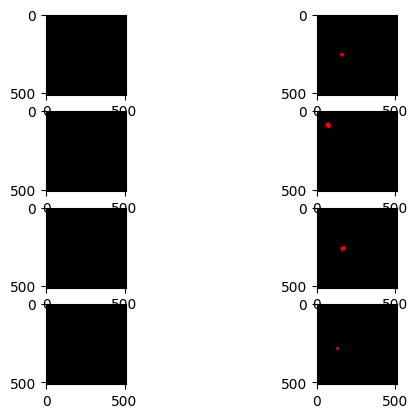

In [16]:
color_map = {
    0:(0,0,0),
    1:(0,0,255),
    2:(255,0,0)
}

def prediction_to_vis(prediction):
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape)
    for i,c in color_map.items():
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8))

for batch in test_dataloader:
    images, masks = batch['pixel_values'], batch['labels']
    outputs = segformer_finetuner.model(images, masks)
        
    loss, logits = outputs[0], outputs[1]

    upsampled_logits = nn.functional.interpolate(
        logits, 
        size=masks.shape[-2:], 
        mode="bilinear", 
        align_corners=False
    )

    predicted = upsampled_logits.argmax(dim=1).cpu().numpy()
    masks = masks.cpu().numpy()
    break

from matplotlib import pyplot as plt
f, axarr = plt.subplots(predicted.shape[0],2)
for i in range(predicted.shape[0]):
    axarr[i,0].imshow(prediction_to_vis(predicted[i,:,:]))
    axarr[i,1].imshow(prediction_to_vis(masks[i,:,:]))